**Nama  : Maylani Kusuma Wardhani**

---

**NIM   : 202210370311123**

---
**Kelas : Machine Learning A**


**UJIAN AKHIR PRAKTIKUM**

**🌿 Herbal Leaf Classification🌿**

In [ ]:
!pip install imgaug opencv-python tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 21.6 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
!pip install seaborn


In [ ]:
import zipfile
import os

zip_path = "/content/Indonesian Herb Leaf Dataset 3500.zip"
extract_path = "/content/dataset/"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)
print("Folder list:", os.listdir(extract_path))

Dataset extracted to: /content/dataset/
Folder list: ['Indonesian Herb Leaf Dataset 3500']


In [ ]:
for folder in os.listdir("/content/dataset/"):
    print(folder)

Indonesian Herb Leaf Dataset 3500


In [ ]:
import os

inner_path = "/content/dataset/Indonesian Herb Leaf Dataset 3500/"

print(os.listdir(inner_path))


['Kemangi', 'Belimbing Wuluh', 'Jeruk Nipis', 'Nangka', 'Sirih', 'Lidah Buaya', 'Seledri', 'Jambu Biji', 'Pandan', 'Pepaya']


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm

# Folder input dataset asli
source_dir = "/content/dataset/Indonesian Herb Leaf Dataset 3500/"

# Folder output dataset baru
output_dir = "/content/dataset_augmented_new/"

# Minimal total gambar sesuai UAP
target_dataset_size = 5500

os.makedirs(output_dir, exist_ok=True)

# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# =========================
# Salin dataset asli dulu
# =========================

total_images = 0

for class_name in os.listdir(source_dir):

    class_input = os.path.join(source_dir, class_name)
    class_output = os.path.join(output_dir, class_name)

    os.makedirs(class_output, exist_ok=True)

    for img_name in tqdm(os.listdir(class_input), desc=f"Copying {class_name}"):

        img_path = os.path.join(class_input, img_name)

        img = load_img(img_path)

        img.save(os.path.join(class_output, img_name))

        total_images += 1


# =========================
# Augmentasi sampai ≥ 5000
# =========================

print("\nAugmenting Dataset...\n")

while total_images < target_dataset_size:

    for class_name in os.listdir(source_dir):

        class_input = os.path.join(source_dir, class_name)
        class_output = os.path.join(output_dir, class_name)

        for img_name in os.listdir(class_input):

            img_path = os.path.join(class_input, img_name)

            img = load_img(img_path)

            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            gen = datagen.flow(
                x,
                batch_size=1,
                save_to_dir=class_output,
                save_prefix="aug",
                save_format="jpg"
            )

            next(gen)

            total_images += 1

            if total_images >= target_dataset_size:
                break

        if total_images >= target_dataset_size:
            break

print("\n=======================================")
print("Augmentasi selesai!")
print("Total gambar sekarang:", total_images)
print("Disimpan di:", output_dir)
print("=======================================\n")

Copying Pepaya: 100%|██████████| 350/350 [00:06<00:00, 51.97it/s]



Augmenting Dataset...


Augmentasi selesai!
Total gambar sekarang: 5500
Disimpan di: /content/dataset_augmented_new/



In [ ]:
import os

root = "/content/dataset_augmented_new/"

count = 0
for path, subdirs, files in os.walk(root):
    for file in files:
        if file.endswith((".jpg", ".jpeg", ".png")):
            count += 1

print("Total image files in dataset_augmented =", count)

Total image files in dataset_augmented = 5474


In [ ]:
import shutil
from google.colab import files

# Make zip
shutil.make_archive('/content/dataset_augmented_new', 'zip', '/content/dataset_augmented_new')

# Download
files.download('/content/dataset_augmented_new.zip')


In [ ]:
import zipfile
import os

zip_path = "/content/dataset_augmented_new.zip"
extract_path = "/content/dataset_augmented_new/"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)
print("Folder list:", os.listdir(extract_path))

Dataset extracted to: /content/dataset_augmented_new/
Folder list: ['Jambu Biji', 'Pandan', 'Pepaya', 'Nangka', 'Seledri', 'Lidah Buaya', 'Jeruk Nipis', 'Belimbing Wuluh', 'Kemangi', 'Sirih']


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os, shutil, random
from google.colab import files

# ===============================
# KONFIGURASI DATASET
# ===============================

dataset_dir = "/content/dataset_augmented_new/"
output_dir  = "/content/dataset_final/"  # folder output fisik

img_size    = (224,224)
batch_size  = 32
seed_value  = 42

# ===============================
# LOAD DATASET + SPLIT TRAIN/VAL/TEST
# ===============================

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed_value,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

valtest_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed_value,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names

valtest_batches = tf.data.experimental.cardinality(valtest_ds)
test_ds = valtest_ds.take(valtest_batches // 2)
val_ds  = valtest_ds.skip(valtest_batches // 2)

# ===============================
# PREPROCESS (NORMALIZE)
# ===============================

normalizer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalizer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalizer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalizer(x), y))

# ===============================
# PIPELINE OPTIMISATION
# ===============================

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

print("\nDataset preprocess completed!")

# ======================================================
# ======================================================
# BAGIAN BARU: BUAT FOLDER TRAIN/VAL/TEST FISIK + COPY FILE
# ======================================================
# ======================================================

train_folder = os.path.join(output_dir, "train")
val_folder   = os.path.join(output_dir, "val")
test_folder  = os.path.join(output_dir, "test")

for d in [train_folder, val_folder, test_folder]:
    os.makedirs(d, exist_ok=True)

split_train = 0.8
split_val   = 0.1
split_test  = 0.1

for cls in os.listdir(dataset_dir):

    src_path = os.path.join(dataset_dir, cls)

    if not os.path.isdir(src_path):
        continue

    imgs = os.listdir(src_path)
    random.shuffle(imgs)

    total = len(imgs)
    t_end = int(total * split_train)
    v_end = t_end + int(total * split_val)

    os.makedirs(os.path.join(train_folder, cls), exist_ok=True)
    os.makedirs(os.path.join(val_folder, cls), exist_ok=True)
    os.makedirs(os.path.join(test_folder, cls), exist_ok=True)

    # copy train
    for img in imgs[:t_end]:
        shutil.copy(os.path.join(src_path, img),
                    os.path.join(train_folder, cls))

    # copy val
    for img in imgs[t_end:v_end]:
        shutil.copy(os.path.join(src_path, img),
                    os.path.join(val_folder, cls))

    # copy test
    for img in imgs[v_end:]:
        shutil.copy(os.path.join(src_path, img),
                    os.path.join(test_folder, cls))

print("File splitting completed!")




Found 5474 files belonging to 10 classes.
Using 4380 files for training.
Found 5474 files belonging to 10 classes.
Using 1094 files for validation.

Dataset preprocess completed!
File splitting completed!


# **CNN BASELINE**


In [ ]:
# =====================================================
# IMPORT LIBRARY
# =====================================================
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# Model ini membutuhkan dataset yang sudah kamu buat sebelumnya:
# train_ds, val_ds, test_ds, class_names

# =====================================================
# 1️⃣ MEMBANGUN ARSITEKTUR CNN SECARA MANUAL
# =====================================================

# Kita menggunakan model Sequential → layer ditumpuk berurutan
model = models.Sequential([

    # ----------------- CONV BLOCK 1 -------------------
    # Conv2D berfungsi mengekstraksi fitur dari gambar (tepi, pola warna, bentuk)
    # 32 filter dengan ukuran kernel 3x3
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),

    # MaxPooling mengecilkan dimensi dan mengurangi noise
    layers.MaxPooling2D((2,2)),

    # ----------------- CONV BLOCK 2 -------------------
    # Layer lebih dalam → belajar fitur yang lebih kompleks
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # ----------------- CONV BLOCK 3 -------------------
    # Semakin banyak filter → semakin detail fitur daun dipahami
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # ----------------- FLATTEN ------------------------
    # Mengubah feature map menjadi vektor agar bisa masuk ke dense layer
    layers.Flatten(),

    # ----------------- FULLY CONNECTED ----------------
    # Dense layer sebagai decision making
    layers.Dense(128, activation='relu'),

    # Dropout mencegah overfitting dengan menghilangkan neuron acak saat training
    layers.Dropout(0.3),

    # ---------------- OUTPUT LAYER --------------------
    # Softmax memberikan peluang untuk setiap class daun
    layers.Dense(len(class_names), activation='softmax')
])

# Menampilkan struktur model
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Kompilasi Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # teknik optimasi gradient descent
    loss='categorical_crossentropy',                          # loss untuk multi-class classification
    metrics=['accuracy']                                      # monitor performa model
)

In [ ]:
#Training Model
epochs = 20  # jumlah pengulangan training seluruh dataset

history = model.fit(
    train_ds,           # dataset training
    validation_data=val_ds,
    epochs=epochs       # semakin banyak epoch → akurasi naik (hingga titik optimal)
)


Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.2595 - loss: 2.3286 - val_accuracy: 0.5364 - val_loss: 1.2768
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.5339 - loss: 1.3009 - val_accuracy: 0.6545 - val_loss: 0.9843
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6728 - loss: 0.9053 - val_accuracy: 0.7236 - val_loss: 0.8064
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7400 - loss: 0.6984 - val_accuracy: 0.7345 - val_loss: 0.7579
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8168 - loss: 0.5092 - val_accuracy: 0.7455 - val_loss: 0.6717
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8550 - loss: 0.4206 - val_accuracy: 0.7382 - val_loss: 0.7070
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9002 - loss: 0.2827 - val_accuracy: 0.7364 - val_loss: 1.0157
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.8950 - loss: 0.2809 - val_a

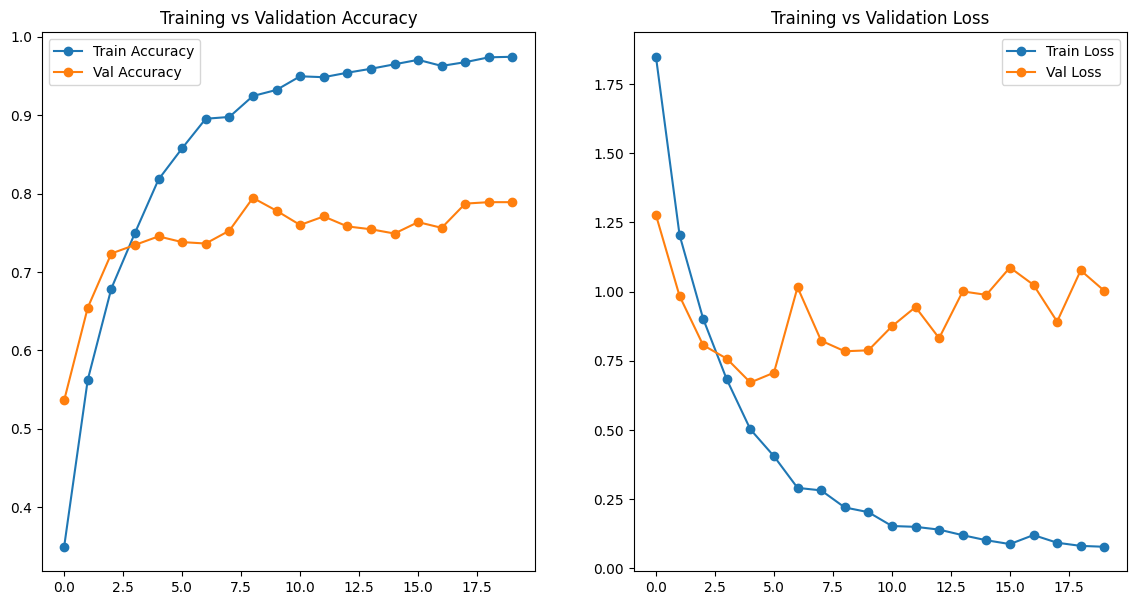

In [ ]:
#VISUALISASI AKURASI & LOSS
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss    = history.history['loss']
val_loss= history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14,7))

# Plot Accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, marker="o", label="Train Accuracy")
plt.plot(epochs_range, val_acc, marker="o", label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, marker="o", label="Train Loss")
plt.plot(epochs_range, val_loss, marker="o", label="Val Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


In [ ]:
#Evaluasi Kinerja Model Pada Test Dataset
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy =", test_acc)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.7750 - loss: 1.1704
Test Accuracy = 0.783088207244873


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


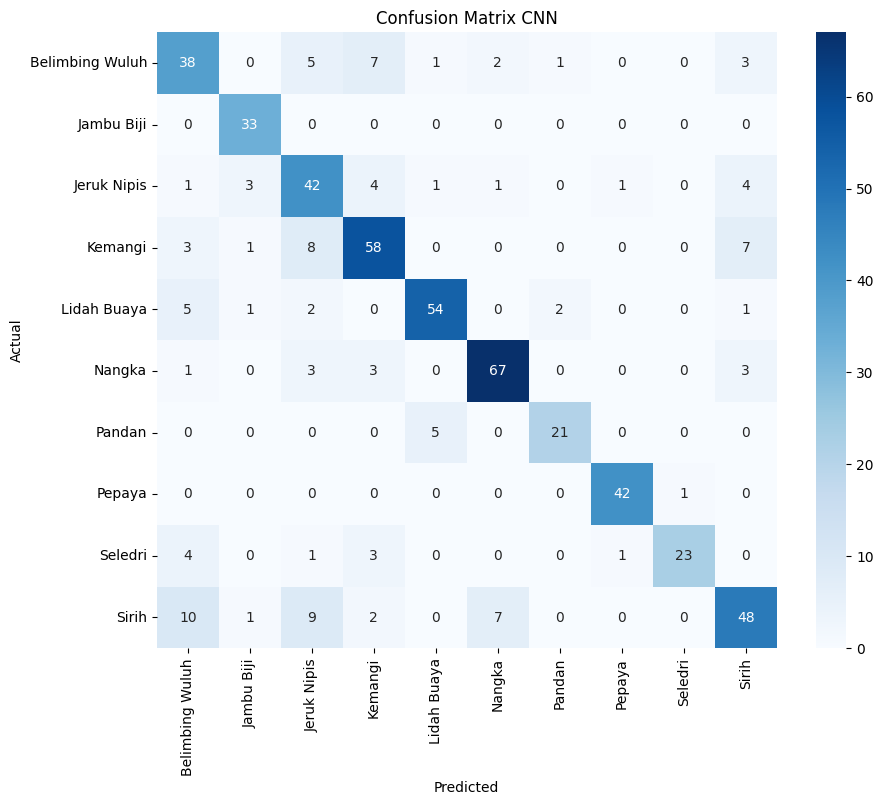

Classification Report:

                 precision    recall  f1-score   support

Belimbing Wuluh       0.61      0.67      0.64        57
     Jambu Biji       0.85      1.00      0.92        33
    Jeruk Nipis       0.60      0.74      0.66        57
        Kemangi       0.75      0.75      0.75        77
    Lidah Buaya       0.89      0.83      0.86        65
         Nangka       0.87      0.87      0.87        77
         Pandan       0.88      0.81      0.84        26
         Pepaya       0.95      0.98      0.97        43
        Seledri       0.96      0.72      0.82        32
          Sirih       0.73      0.62      0.67        77

       accuracy                           0.78       544
      macro avg       0.81      0.80      0.80       544
   weighted avg       0.79      0.78      0.78       544



In [ ]:
# Confusion Matrix & Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for x, y in test_ds:
    pred = model.predict(x)
    y_pred.extend(tf.argmax(pred, axis=1))
    y_true.extend(tf.argmax(y, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.title("Confusion Matrix CNN")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
#Simpan Model
model.save("cnn_leaf_model.keras")

In [ ]:
import json

with open("class_names.json", "w") as f:
    json.dump(class_names, f)


In [ ]:
model_cnn = model


In [ ]:
model_cnn = tf.keras.models.load_model("cnn_leaf_model.keras")

# **TRANSFER LEARNING - MOBILENETV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Download MobileNetV2 pretrained dari ImageNet
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Bekukan layer base model → agar fitur tidak berubah dulu
base_model.trainable = False

In [ ]:
model_mobilenet = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model_mobilenet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model_mobilenet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
earlystop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_tl1 = model_mobilenet.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
    callbacks=[earlystop]
)

Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 72s 320ms/step - accuracy: 0.3741 - loss: 1.8882 - val_accuracy: 0.8709 - val_loss: 0.5259
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8392 - loss: 0.5573 - val_accuracy: 0.9127 - val_loss: 0.3045
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8982 - loss: 0.3536 - val_accuracy: 0.9218 - val_loss: 0.2265
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9236 - loss: 0.2636 - val_accuracy: 0.9436 - val_loss: 0.1864
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9405 - loss: 0.2031 - val_accuracy: 0.9527 - val_loss: 0.1509
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9492 - loss: 0.1724 - val_accuracy: 0.9582 - val_loss: 0.1332
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9510 - loss: 0.1605 - val_accuracy: 0.9655 - val_loss: 0.1192
Epoch 8/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9591 - loss: 0.1367 - val_ac

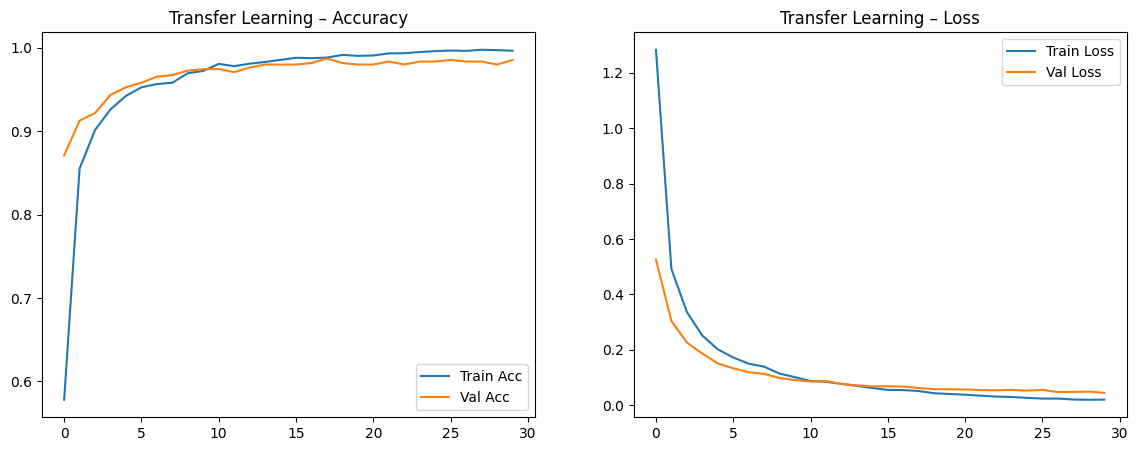

In [ ]:
acc     = history_tl1.history['accuracy']
val_acc = history_tl1.history['val_accuracy']
loss    = history_tl1.history['loss']
val_loss= history_tl1.history['val_loss']

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.legend()
plt.title("Transfer Learning – Accuracy")

plt.subplot(1,2,2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Transfer Learning – Loss")

plt.show()

In [ ]:
test_loss, test_acc = model_mobilenet.evaluate(test_ds)
print("Test Accuracy (MobileNetV2) =", test_acc)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9793 - loss: 0.0691
Test Accuracy (MobileNetV2) = 0.9779411554336548


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


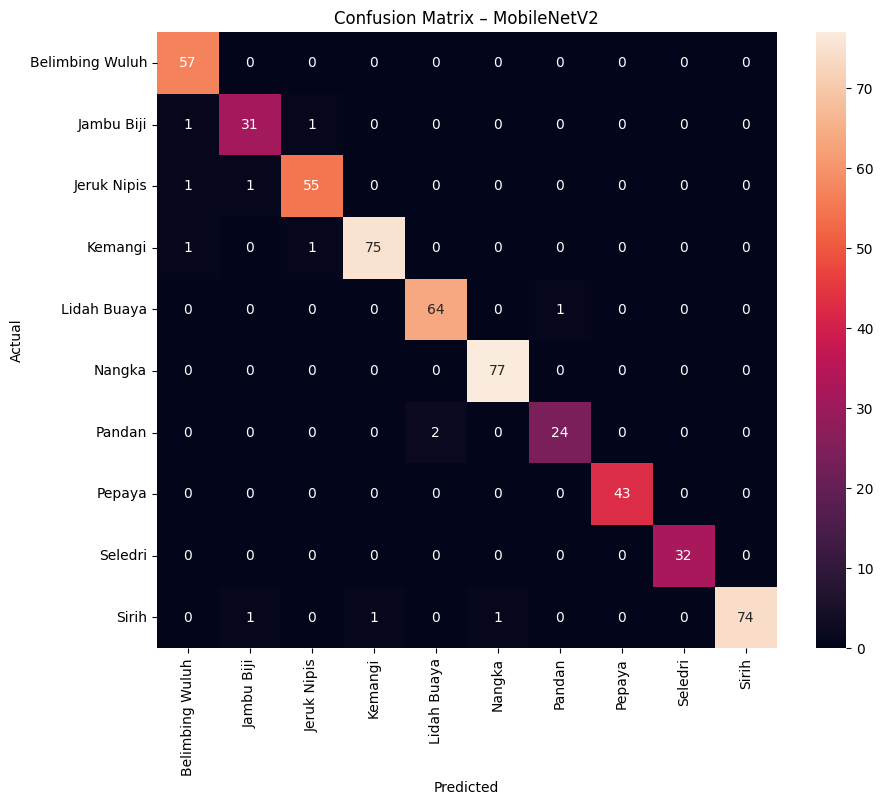

Classification Report – MobileNetV2:
                 precision    recall  f1-score   support

Belimbing Wuluh       0.95      1.00      0.97        57
     Jambu Biji       0.94      0.94      0.94        33
    Jeruk Nipis       0.96      0.96      0.96        57
        Kemangi       0.99      0.97      0.98        77
    Lidah Buaya       0.97      0.98      0.98        65
         Nangka       0.99      1.00      0.99        77
         Pandan       0.96      0.92      0.94        26
         Pepaya       1.00      1.00      1.00        43
        Seledri       1.00      1.00      1.00        32
          Sirih       1.00      0.96      0.98        77

       accuracy                           0.98       544
      macro avg       0.98      0.97      0.98       544
   weighted avg       0.98      0.98      0.98       544



In [ ]:
# Confusion Matrix & Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

y_true=[]
y_pred=[]

for x,y in test_ds:
    pred = model_mobilenet.predict(x)
    y_pred.extend(np.argmax(pred, axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix – MobileNetV2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report – MobileNetV2:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Simpan model lengkap
model_mobilenet.save("mobilenetv2_leaf_model.keras")  # folder berisi SavedModel

In [ ]:
model_mobilenet = model_tl1


# **TRANSFER LEARNING - RESNET50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# 1. Load Base Model ResNet50 (Pre-trained pada ImageNet)
# include_top=False artinya kita membuang lapisan klasifikasi asli ResNet (1000 kelas)
base_model_resnet = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2. Freeze Base Model (Kunci bobot agar tidak berubah saat awal training)
base_model_resnet.trainable = False

# 3. Rakit Model Baru
model_resnet = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)), # <--- WAJIB TAMBAHKAN INI
    base_model_resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# 4. Compile Model
model_resnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Buat callback EarlyStopping
earlystop = EarlyStopping(
    monitor='val_loss',      # memonitor nilai val_loss
    patience=10,              # jika 5 epoch tidak membaik -> stop
    restore_best_weights=True # kembalikan bobot terbaik
)

# Jalankan proses training
epochs = 50

history = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[earlystop]   # panggil callback
)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 37s 167ms/step - accuracy: 0.2133 - loss: 2.1826 - val_accuracy: 0.3800 - val_loss: 1.7158
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.3873 - loss: 1.6526 - val_accuracy: 0.4982 - val_loss: 1.4530
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.4309 - loss: 1.4759 - val_accuracy: 0.5127 - val_loss: 1.3470
Epoch 4/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.4718 - loss: 1.3731 - val_accuracy: 0.5345 - val_loss: 1.2652
Epoch 5/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5079 - loss: 1.2862 - val_accuracy: 0.5509 - val_loss: 1.2110
Epoch 6/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5475 - loss: 1.2260 - val_accuracy: 0.5764 - val_loss: 1.1876
Epoch 7/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5366 - loss: 1.2334 - val_accuracy: 0.6018 - val_loss: 1.1475
Epoch 8/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.5229 - loss: 1.2140 - val_ac

NameError: name 'model' is not defined

In [ ]:
# Evaluasi menggunakan test_ds
print("\n--- Evaluasi Data Test ---")
loss, acc = model_resnet.evaluate(test_ds)
print(f"Akurasi pada data test: {acc*100:.2f}%")


--- Evaluasi Data Test ---
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6819 - loss: 0.9339
Akurasi pada data test: 68.57%


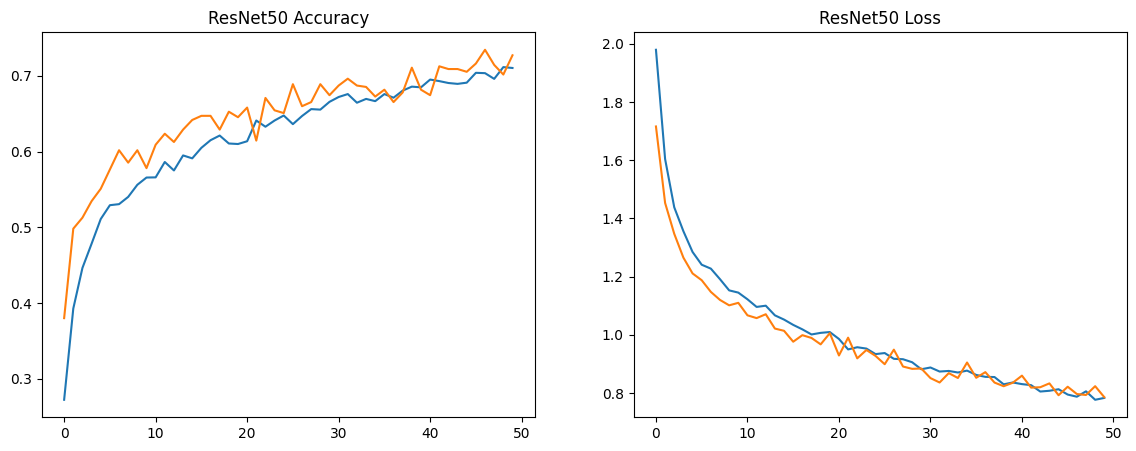

In [ ]:
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss    = history.history['loss']
val_loss= history.history['val_loss']

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.title("ResNet50 Accuracy")

plt.subplot(1,2,2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("ResNet50 Loss")

plt.show()

In [ ]:
test_loss, test_acc = model_resnet.evaluate(test_ds)
print(f"\nResNet50 Test Accuracy = {test_acc*100:.2f}%")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6819 - loss: 0.9339

ResNet50 Test Accuracy = 68.57%


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


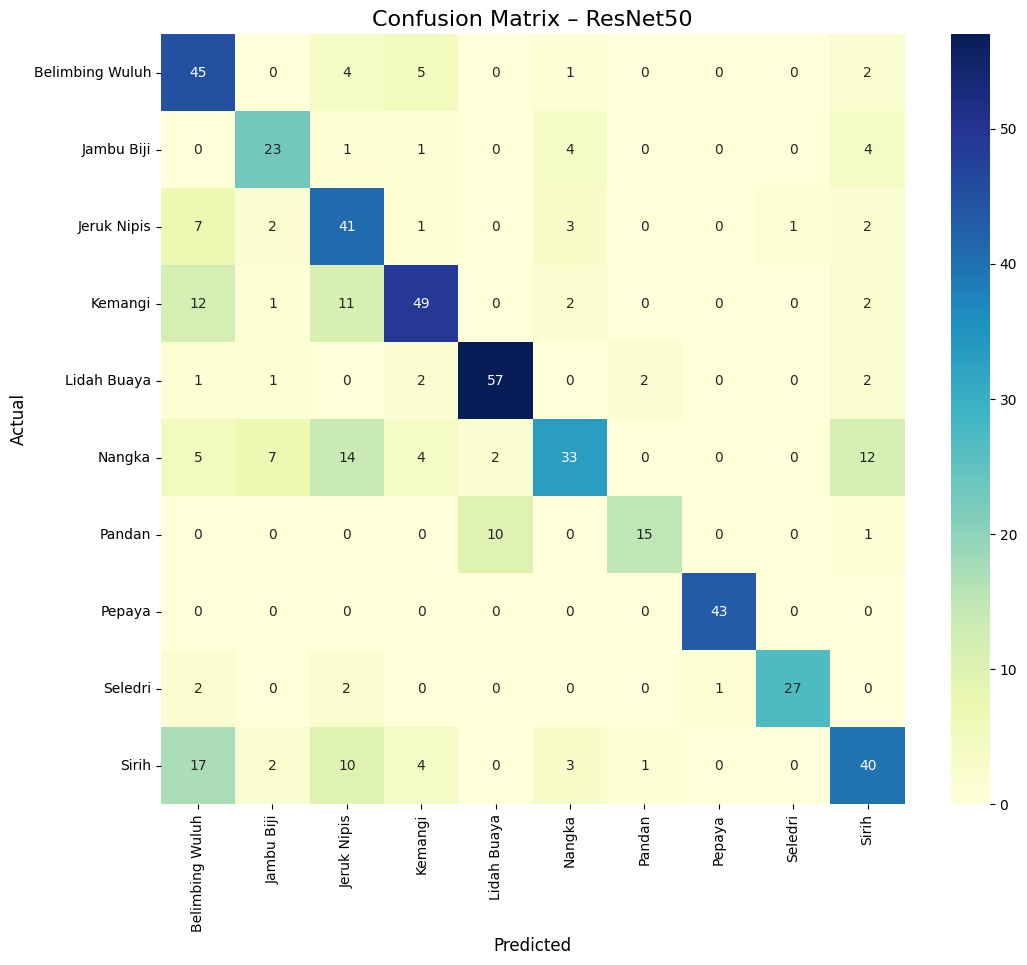

Classification Report – ResNet50:

                 precision    recall  f1-score   support

Belimbing Wuluh       0.51      0.79      0.62        57
     Jambu Biji       0.64      0.70      0.67        33
    Jeruk Nipis       0.49      0.72      0.59        57
        Kemangi       0.74      0.64      0.69        77
    Lidah Buaya       0.83      0.88      0.85        65
         Nangka       0.72      0.43      0.54        77
         Pandan       0.83      0.58      0.68        26
         Pepaya       0.98      1.00      0.99        43
        Seledri       0.96      0.84      0.90        32
          Sirih       0.62      0.52      0.56        77

       accuracy                           0.69       544
      macro avg       0.73      0.71      0.71       544
   weighted avg       0.71      0.69      0.68       544



In [ ]:
# Confusion Matrix & Classification Report
y_true = []
y_pred = []

for x, y in test_ds:
    pred = model_resnet.predict(x)
    y_pred.extend(np.argmax(pred, axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix – ResNet50", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report – ResNet50:\n")
print(report)

In [ ]:
# Simpan model lengkap
model_resnet.save("resnet50_leaf_model.keras")  # folder berisi SavedModel

In [ ]:
model_resnet = model


In [ ]:
model_resnet = tf.keras.models.load_model("resnet50_leaf_model.keras")

# **TRANSFER LEARNING - VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Ambil nama kelas otomatis (jika belum punya manual)
num_classes = len(class_names)

# Load VGG16 (tanpa fully-connected, pretrained ImageNet)
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Freeze semua layer awal → biarkan weight ImageNet
for layer in base_model.layers:
    layer.trainable = False

# Bangun bagian atas model
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation="softmax")(x)

# Final model
model_vgg = Model(inputs=base_model.input, outputs=output)

# Kompilasi model
model_vgg.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,29

 Total params: 21,171,658 (80.76 MB)

 Trainable params: 6,456,970 (24.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model_vgg.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[earlystop]
)

Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 62s 331ms/step - accuracy: 0.3260 - loss: 1.9075 - val_accuracy: 0.8182 - val_loss: 0.7946
Epoch 2/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 188ms/step - accuracy: 0.6906 - loss: 0.9302 - val_accuracy: 0.8564 - val_loss: 0.5526
Epoch 3/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - accuracy: 0.7894 - loss: 0.6793 - val_accuracy: 0.8818 - val_loss: 0.3904
Epoch 4/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 190ms/step - accuracy: 0.8450 - loss: 0.5049 - val_accuracy: 0.9073 - val_loss: 0.3116
Epoch 5/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - accuracy: 0.8784 - loss: 0.4129 - val_accuracy: 0.9127 - val_loss: 0.2850
Epoch 6/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - accuracy: 0.9027 - loss: 0.3097 - val_accuracy: 0.9236 - val_loss: 0.2276
Epoch 7/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - accuracy: 0.9177 - loss: 0.2812 - val_accuracy: 0.9382 - val_loss: 0.2237
Epoch 8/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - accuracy: 0.9311 - loss: 0

In [ ]:
loss, acc = model_vgg.evaluate(test_ds)
print(f"Accuracy Test VGG16: {acc*100:.2f}%")

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9550 - loss: 0.1588
Accuracy Test VGG16: 95.77%


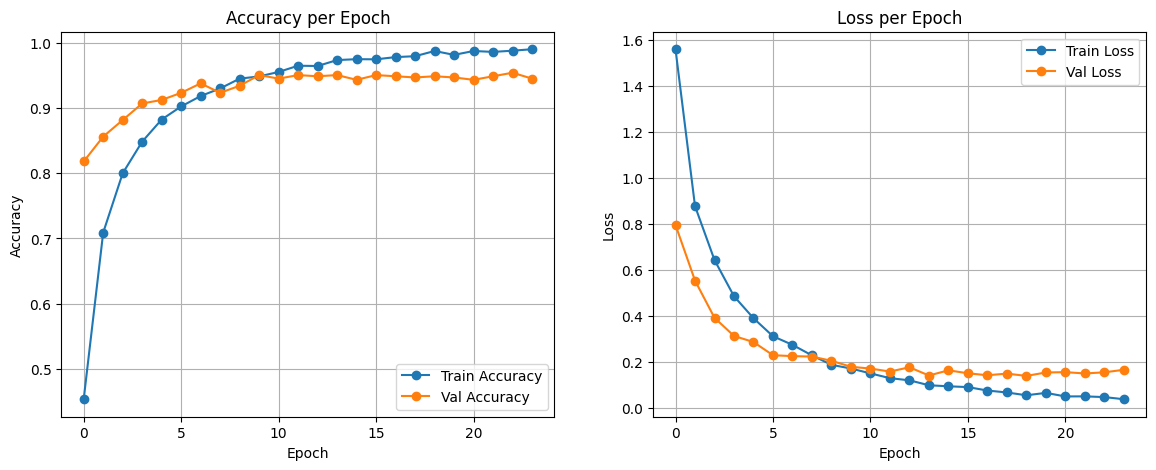

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy & Loss
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


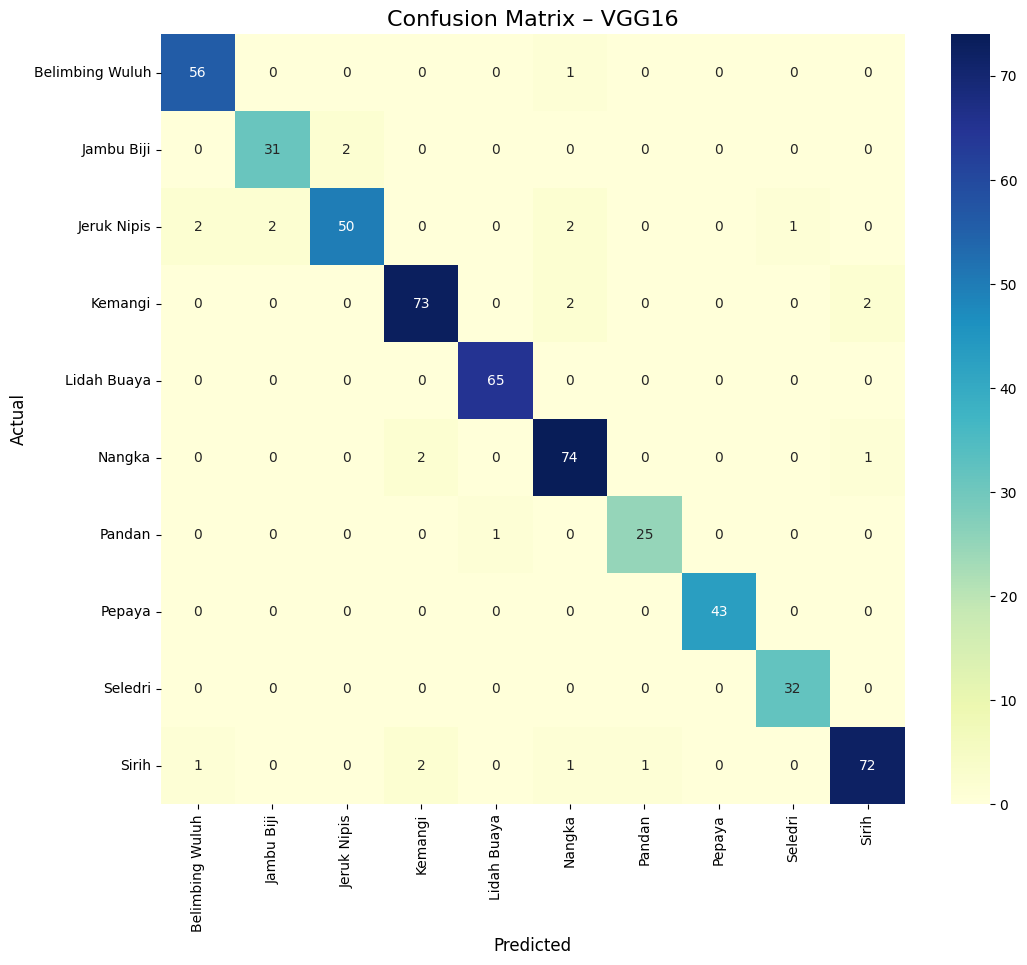

Classification Report – VGG16:

                 precision    recall  f1-score   support

Belimbing Wuluh       0.95      0.98      0.97        57
     Jambu Biji       0.94      0.94      0.94        33
    Jeruk Nipis       0.96      0.88      0.92        57
        Kemangi       0.95      0.95      0.95        77
    Lidah Buaya       0.98      1.00      0.99        65
         Nangka       0.93      0.96      0.94        77
         Pandan       0.96      0.96      0.96        26
         Pepaya       1.00      1.00      1.00        43
        Seledri       0.97      1.00      0.98        32
          Sirih       0.96      0.94      0.95        77

       accuracy                           0.96       544
      macro avg       0.96      0.96      0.96       544
   weighted avg       0.96      0.96      0.96       544



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

y_true = []
y_pred = []

# Ambil prediksi dari test set
for x, y in test_ds:
    pred = model_vgg.predict(x)
    y_pred.extend(np.argmax(pred, axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix – VGG16", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report – VGG16:\n")
print(report)

In [ ]:
# Simpan model lengkap
model_vgg.save("vgg16_leaf_model.keras")  # folder berisi SavedModel

# **SUMMARY PERBANDINGAN**

=== TABEL METRIK (DESIMAL) ===


,Model,Accuracy,Precision,Recall,F1-Score
0,CNN Manual,0.783088,0.790555,0.783088,0.783830
1,MobileNetV2,0.981618,0.982048,0.981618,0.981500
2,ResNet50,0.689338,0.701516,0.689338,0.691575
3,VGG16,0.957721,0.957904,0.957721,0.957487


=== TABEL METRIK (PERSEN) ===


,Model,Accuracy,Precision,Recall,F1-Score
0,CNN Manual,78.31,79.06,78.31,78.38
1,MobileNetV2,98.16,98.20,98.16,98.15
2,ResNet50,68.93,70.15,68.93,69.16
3,VGG16,95.77,95.79,95.77,95.75


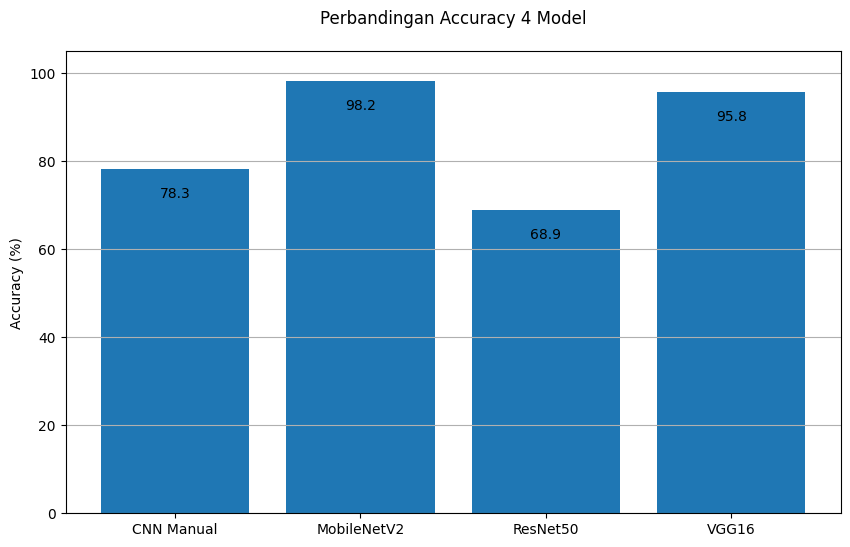

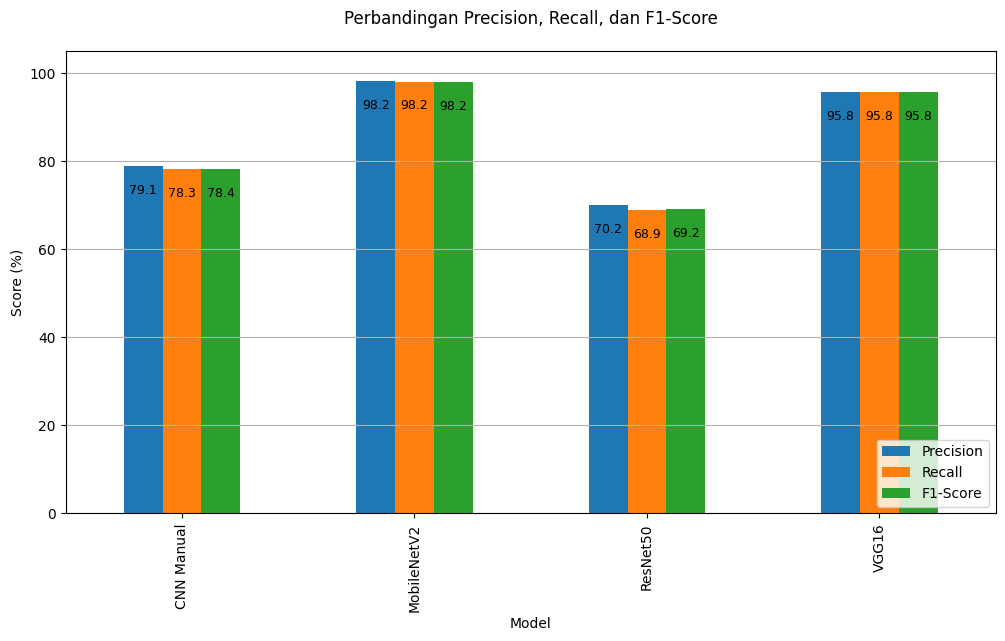

In [ ]:
# =====================================================
# IMPORT LIBRARY
# =====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# =====================================================
# FUNGSI EVALUASI MODEL
# =====================================================
def evaluate_model(model, test_ds):
    y_true = []
    y_pred = []

    for x, y in test_ds:
        pred = model.predict(x, verbose=0)
        y_pred.extend(np.argmax(pred, axis=1))
        y_true.extend(np.argmax(y, axis=1))

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    return acc, precision, recall, f1

# =====================================================
# HITUNG METRIK KESELURUHAN 4 MODEL
# =====================================================
results = []

# 1️⃣ CNN Manual
acc, prec, rec, f1 = evaluate_model(model_cnn, test_ds)
results.append(["CNN Manual", acc, prec, rec, f1])

# 2️⃣ MobileNetV2
acc, prec, rec, f1 = evaluate_model(model_mobilenet, test_ds)
results.append(["MobileNetV2", acc, prec, rec, f1])

# 3️⃣ ResNet50
acc, prec, rec, f1 = evaluate_model(model_resnet, test_ds)
results.append(["ResNet50", acc, prec, rec, f1])

# 4️⃣ VGG16
acc, prec, rec, f1 = evaluate_model(model_vgg, test_ds)
results.append(["VGG16", acc, prec, rec, f1])

# =====================================================
# TABEL SUMMARY (DESIMAL)
# =====================================================
df_results = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

print("=== TABEL METRIK (DESIMAL) ===")
display(df_results)

# =====================================================
# TABEL SUMMARY (PERSEN – UNTUK LAPORAN)
# =====================================================
df_percent = df_results.copy()
for col in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    df_percent[col] = (df_percent[col] * 100).round(2)

print("=== TABEL METRIK (PERSEN) ===")
display(df_percent)

# =====================================================
# VISUALISASI 1: BAR CHART ACCURACY + LABEL %
# =====================================================
plt.figure(figsize=(10,6))
bars = plt.bar(df_percent["Model"], df_percent["Accuracy"])

plt.title("Perbandingan Accuracy 4 Model", pad=20)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 105)  # ⬅️ FIX
plt.grid(axis="y")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height - 4,          # ⬅️ masuk ke batang
        f"{height:.1f}",
        ha="center",
        va="top",
        fontsize=10,
        color="black"
    )

plt.show()


# =====================================================
# VISUALISASI 2: PRECISION, RECALL, F1-SCORE + LABEL %
# =====================================================
metrics = ["Precision", "Recall", "F1-Score"]

ax = df_percent.set_index("Model")[metrics].plot(
    kind="bar",
    figsize=(12,6)
)

plt.title("Perbandingan Precision, Recall, dan F1-Score", pad=20)
plt.ylabel("Score (%)")
plt.ylim(0, 105)  # ⬅️ FIX UTAMA
plt.grid(axis="y")
plt.legend(loc="lower right")

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.annotate(
            f"{height:.1f}",
            (bar.get_x() + bar.get_width()/2, height - 4),  # ⬅️ masuk ke batang
            ha="center",
            va="top",
            fontsize=9,
            color="black"
        )

plt.show()



In [1]:
import tensorflow as tf
import keras

print(f"Versi TensorFlow: {tf.__version__}")
print(f"Versi Keras: {keras.__version__}")

Versi TensorFlow: 2.19.0
Versi Keras: 3.10.0
